In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


In [72]:
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [74]:
path= r'C:\Users\Lenovo\Desktop\diabetes.csv'
df= pd.read_csv(path)
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.900,0.171,63,0
764,2,122,70,27,0,36.800,0.340,27,0
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1


### Veri setini tanıma

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Değişkenler

* Pregnancies: Hamilelik sayısı
* Glucose: Glikoz
* BloodPressure: Kan basıncı
* SkinThickness: Cilt Kalınlığı
* Insulin: İnsülin
* BMI: Beden kitle indeksi
* DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon
* Age: Yaş 
* Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

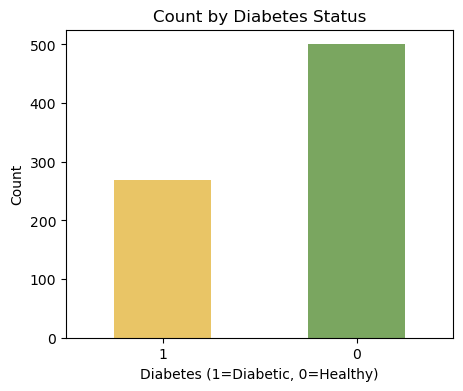

In [30]:
#Diabet olma durumlarına göre kişi sayısı

df["Outcome"] = df["Outcome"].astype(str)   #hata almamak için str yapıldı


plt.figure(figsize=(5, 4))
sns.countplot(x="Outcome", data=df, width=0.5, palette={"0": "#77B254", "1": "#FFCF50"})
plt.xlabel("Diabetes (1=Diabetic, 0=Healthy)")
plt.ylabel("Count")
plt.title("Count by Diabetes Status")
plt.show()

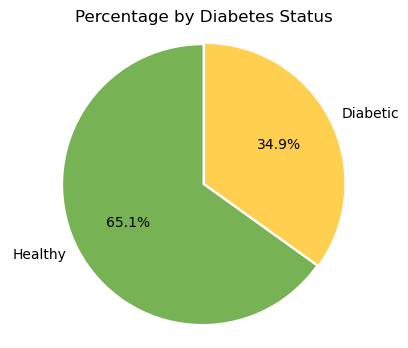

In [32]:
#oranları
labels = ["Healthy", "Diabetic"]
sizes = df["Outcome"].value_counts(normalize=True).sort_index() * 100  
colors = ["#77B254", "#FFCF50"]

plt.figure(figsize=(5, 4))
plt.pie(sizes, labels=labels, autopct="%.1f%%", colors=colors, startangle=90, explode=(0, 0.02))
plt.title("Percentage by Diabetes Status")
plt.axis("equal")
plt.show()

In [34]:
df["Outcome"] = df["Outcome"].astype(int) # hedef değişken orijinal dtype (int) yapıldı

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


Bir insanda Pregnancies ve Outcome dışındaki değerlerin 0 olamayacağı bilinmektedir. Eksik değerlere 0 yazılmış olabilir. Bu nedenle, 0 olan değerler eksik veri olarak değerlendirildi. 

In [76]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])


na_columns = [col for col in df.columns if df[col].isnull().any()]


### Eksik değerler

In [78]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [66]:
#Eksik değer oranları
n_miss = df.isnull().sum()
ratio = (df.isnull().sum() / df.shape[0]) * 100
missing_df = pd.concat([n_miss, ratio], axis=1, keys=["n_miss", "ratio"])
missing_df = missing_df[missing_df["n_miss"] > 0]
print(missing_df)

               n_miss  ratio
Glucose             5  0.651
BloodPressure      35  4.557
SkinThickness     227 29.557
Insulin           374 48.698
BMI                11  1.432


In [68]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi

temp_df = df.copy()

#  Eksik değer olan sütunlara NA_FLAG eklendi
for col in na_columns:
    temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

na_flags = [col for col in temp_df.columns if "_NA_FLAG" in col]

# Her bir flag sütununa göre Outcome ortalaması ve veri sayısı
for col in na_flags:
    result = pd.DataFrame({
        "TARGET_MEAN": temp_df.groupby(col)["Outcome"].mean(),
        "Count": temp_df.groupby(col)["Outcome"].count()
    })
    print(result)
    print("\n\n")


                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5



                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35



                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227



                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374



             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11





* Eksik değerler genelde diyabet riski ile ilişkili gözüküyor. Özellikle BloodPressure, SkinThickness ve Insulin değişkenlerinin, eksik olanlarda (1) diyabet oranı daha yüksek.

* Eksik değerlerin rastgele dağılmadığı ve bağımlı değişken ile ilişkisi olduğu görülüyor. Bu nedenle, eksik değerleri silmek modelde yanlılık (bias) yaratabileceğinden doldurma yöntemleri tercih edilmiştir.


In [84]:
from sklearn.impute import KNNImputer


imputer = KNNImputer(n_neighbors=5)

knn_cols = ["SkinThickness", "Insulin"]


subset_cols = [col for col in df.columns if col not in ["Outcome"]]
df_knn = df[subset_cols].copy()

# KNN ile doldurma
df_knn_imputed = imputer.fit_transform(df_knn)

# Sadece SkinThickness ve Insulin'i güncelle
df["SkinThickness"] = df_knn_imputed[:, df_knn.columns.get_loc("SkinThickness")]
df["Insulin"] = df_knn_imputed[:, df_knn.columns.get_loc("Insulin")]

In [86]:
print(df_knn.isnull().sum())

Pregnancies                  0
Glucose                      5
BloodPressure               35
SkinThickness                0
Insulin                      0
BMI                         11
DiabetesPedigreeFunction     0
Age                          0
dtype: int64


In [88]:
# Diğer NAN değişkenler için doldurma 
median_columns = ["Glucose", "BloodPressure", "BMI"]
df[median_columns] = df[median_columns].fillna(df[median_columns].median())


In [90]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Eksik değerleri doldurma sürecinde, SkinThickness ve Insulin değişkenlerinde eksik veri oranı oldukça yüksek olduğu  için daha gerçekçi ve veri yapısına uygun tahminler elde etmek amacıyla KNN imputer yöntemi tercih edilmiştir. Diğer taraftan, Glucose, BloodPressure ve BMI değişkenlerinde eksik değer oranı oldukça düşüktü ve bu değişkenlerin dağılımı daha homojendi. Bu nedenle, bu değişkenlerde basit ve etkili bir yöntem olan medyan ile doldurma uygulanmıştır.

### Aykırı değer analizi

In [96]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):  # uç değerler daha geniş aralıkta verildi
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [98]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


### Model kurma 

In [129]:
# Lojistik regresyon

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred), 2)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred), 2)}")


Accuracy: 0.77
Recall: 0.64
Precision: 0.69
F1: 0.66
Auc: 0.74


In [201]:
# Random forest

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_rf), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_rf), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_rf), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_rf), 2)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred_rf), 2)}")

Accuracy: 0.75
Recall: 0.71
Precision: 0.63
F1: 0.67
Auc: 0.74


In [119]:
# Knn 

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_knn), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_knn), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_knn), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_knn), 2)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred_knn), 2)}")


Accuracy: 0.72
Recall: 0.71
Precision: 0.59
F1: 0.64
Auc: 0.72


In [199]:
#LightGBM

lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_lgbm), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_lgbm), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_lgbm), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_lgbm), 2)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred_lgbm), 2)}")

Accuracy: 0.77
Recall: 0.76
Precision: 0.65
F1: 0.7
Auc: 0.77


In [ ]:
"""
Accuracy: Kaç tahmin doğru çıktı? (Tüm tahminler içinde)

Recall: Gerçek pozitiflerin kaçı bulundu? (Kaç hastayı yakaladık?)

Precision: Pozitif dediğimiz örneklerin kaçı gerçekten pozitif? (Kaç hastaya yanlış teşhis koymadık?)

F1: Precision ve recall’un dengesi.

AUC: Modelin her tür eşik değerinde pozitif-negatif ayırabilme başarısı."""

### Feature engineering

In [100]:
new_df= df.copy()

In [102]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
# Sınırlar WHO kiriterlerine göre belirlendi

new_df["New_BMI"]= pd.cut(x=df["BMI"], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [104]:
"""
WHO’ya Göre Sınırlar:
Normal: < 110 mg/dL

Prediabetes (Impaired Fasting Glucose): 110–125 mg/dL

Diabetes: ≥ 126 mg/dL
"""

# Glukoz degerini kategorik değişkene çevirme
new_df["New_Glucose"] = pd.cut(
    x=df["Glucose"],
    bins=[0, 110, 126, df["Glucose"].max()],
    labels=["Normal", "Prediabetes", "Diabetes"],
    right=False)   # 110 dahil değil, 126 dahil değil; 0-109, 110-125, 126-199)


In [106]:
# İnsulin Değeri ile Kategorik değişken türetmek
                                             
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

new_df["New_Insulin_Score"] = df.apply(set_insulin, axis=1)


In [108]:
new_df["New_Glucose*Insulin"] = df["Glucose"] * df["Insulin"]


new_df["New_Glucose*Pregnancies"] = df["Glucose"] * df["Pregnancies"]


In [110]:
# Label encoding

binary_cols = [
    col for col in new_df.columns
    if (new_df[col].dtype == "O" or str(new_df[col].dtype) == "category") and new_df[col].nunique() == 2
]


for col in binary_cols:
    le = LabelEncoder()
    new_df[col] = le.fit_transform(new_df[col])


In [112]:
new_df["New_Insulin_Score"].value_counts()

New_Insulin_Score
1    507
0    261
Name: count, dtype: int64

Veri setinde, 261 kişinin insülin skoru 0 ( Normal), 507 kişi 1 (Abnormal) olarak kodlandı.

In [114]:
# one-hot encoding

new_df = pd.get_dummies(new_df, columns=["New_BMI", "New_Glucose"], drop_first=False)

In [116]:
new_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Insulin_Score,New_Glucose*Insulin,New_Glucose*Pregnancies,New_BMI_Underweight,New_BMI_Healthy,New_BMI_Overweight,New_BMI_Obese,New_Glucose_Normal,New_Glucose_Prediabetes,New_Glucose_Diabetes
0,6,148.000,72.000,35.000,169.000,33.600,0.627,50,1,0,25012.000,888.000,False,False,False,True,False,False,True
1,1,85.000,66.000,29.000,58.600,26.600,0.351,31,0,1,4981.000,85.000,False,False,True,False,True,False,False
2,8,183.000,64.000,25.800,164.600,23.300,0.672,32,1,1,30121.800,1464.000,False,True,False,False,False,False,True
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,8366.000,89.000,False,False,True,False,True,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,23016.000,0.000,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.000,76.000,48.000,180.000,32.900,0.171,63,0,0,18180.000,1010.000,False,False,False,True,True,False,False
764,2,122.000,70.000,27.000,165.000,36.800,0.340,27,0,1,20130.000,244.000,False,False,False,True,False,True,False
765,5,121.000,72.000,23.000,112.000,26.200,0.245,30,0,1,13552.000,605.000,False,False,True,False,False,True,False
766,1,126.000,60.000,35.200,134.200,30.100,0.349,47,1,1,16909.200,126.000,False,False,False,True,False,False,True


In [66]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   New_Insulin_Score         768 non-null    int32  
 10  New_Glucose*Insulin       768 non-null    int64  
 11  New_Glucose*Pregnancies   768 non-null    int64  
 12  New_BMI_Underweight       768 non-null    bool   
 13  New_BMI_Healthy           768 non-null    bool   
 14  New_BMI_Ov

In [162]:
# StandardScaler 

X_new = new_df.drop("Outcome", axis=1)
y_new = new_df["Outcome"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42)

numeric_cols_new = X_new.select_dtypes(include=["int64", "float64"]).columns.tolist()
scaler = StandardScaler()
X_train_new_scaled = X_train_new.copy()
X_test_new_scaled = X_test_new.copy() 
X_train_new_scaled[numeric_cols_new] = scaler.fit_transform(X_train_new[numeric_cols_new])
X_test_new_scaled[numeric_cols_new] = scaler.transform(X_test_new[numeric_cols_new])

### Feature engineering sonrası model kurma 

In [400]:
# Lojistik regresyon

log_model = LogisticRegression()
log_model.fit(X_train_new_scaled, y_train)
y_pred = log_model.predict(X_test_new_scaled)

print("Lojistik regresyon (new_df + scaled) Sonuçları:")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred), 2)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred), 2)}")

Lojistik regresyon (new_df + scaled) Sonuçları:
Accuracy: 0.73
Recall: 0.65
Precision: 0.61
F1: 0.63
Auc: 0.71


Scaling ve feature öncesi lojistik regresyon sonuçları:

* Accuracy: 0.77
* Recall: 0.64
* Precision: 0.69
* F1: 0.66
* Auc: 0.74

In [203]:
# Random forest model

rf_model_new = RandomForestClassifier()
rf_model_new.fit(X_train_new_scaled, y_train_new)

y_pred_rf_new = rf_model_new.predict(X_test_new_scaled)

print("Random Forest (new_df + scaled) Sonuçları:")
print(f"Accuracy : {round(accuracy_score(y_test_new, y_pred_rf_new), 2)}")
print(f"Recall   : {round(recall_score(y_test_new, y_pred_rf_new), 2)}")
print(f"Precision: {round(precision_score(y_test_new, y_pred_rf_new), 2)}")
print(f"F1       : {round(f1_score(y_test_new, y_pred_rf_new), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new, y_pred_rf_new), 2)}")

Random Forest (new_df + scaled) Sonuçları:
Accuracy : 0.78
Recall   : 0.73
Precision: 0.68
F1       : 0.7
AUC      : 0.77


ilk RandomForestClassifier:

* Accuracy: 0.76
* Recall: 0.67
* Precision: 0.66
* F1: 0.67
* Auc: 0.74

Son Random Forest modelinin başarısı, önceki modele göre daha iyi.
Feature engineering + scaling, bu modeli iyileştirdi.

In [228]:
# KNN

knn_model_new = KNeighborsClassifier()
knn_model_new.fit(X_train_new_scaled, y_train_new)

y_pred_knn_new = knn_model_new.predict(X_test_new_scaled)


print("KNN (new_df + scaled) Sonuçları:")
print(f"Accuracy : {round(accuracy_score(y_test_new, y_pred_knn_new), 2)}")
print(f"Recall   : {round(recall_score(y_test_new, y_pred_knn_new), 2)}")
print(f"Precision: {round(precision_score(y_test_new, y_pred_knn_new), 2)}")
print(f"F1       : {round(f1_score(y_test_new, y_pred_knn_new), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new, y_pred_knn_new), 2)}")

KNN (new_df + scaled) Sonuçları:
Accuracy : 0.77
Recall   : 0.67
Precision: 0.67
F1       : 0.67
AUC      : 0.75


İlk KNN model:

* Accuracy: 0.72
* Recall: 0.71
* Precision: 0.59
* F1: 0.64
* Auc: 0.72

In [446]:
# LightGBM

lgbm_model_new = lgb.LGBMClassifier(random_state=42)
lgbm_model_new.fit(X_train_new_scaled, y_train_new)

y_pred_lgbm_new = lgbm_model_new.predict(X_test_new_scaled)


print("LightGBM (new_df + scaled) Sonuçları:")
print(f"Accuracy : {round(accuracy_score(y_test_new, y_pred_lgbm_new), 2)}")
print(f"Recall   : {round(recall_score(y_test_new, y_pred_lgbm_new), 2)}")
print(f"Precision: {round(precision_score(y_test_new, y_pred_lgbm_new), 3)}")
print(f"F1       : {round(f1_score(y_test_new, y_pred_lgbm_new), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new, y_pred_lgbm_new), 2)}")

LightGBM (new_df + scaled) Sonuçları:
Accuracy : 0.73
Recall   : 0.69
Precision: 0.603
F1       : 0.64
AUC      : 0.72


İlk LightGBM sonuçları:

* Accuracy: 0.77
* Recall: 0.76
* Precision: 0.65
* F1: 0.7
* Auc: 0.77

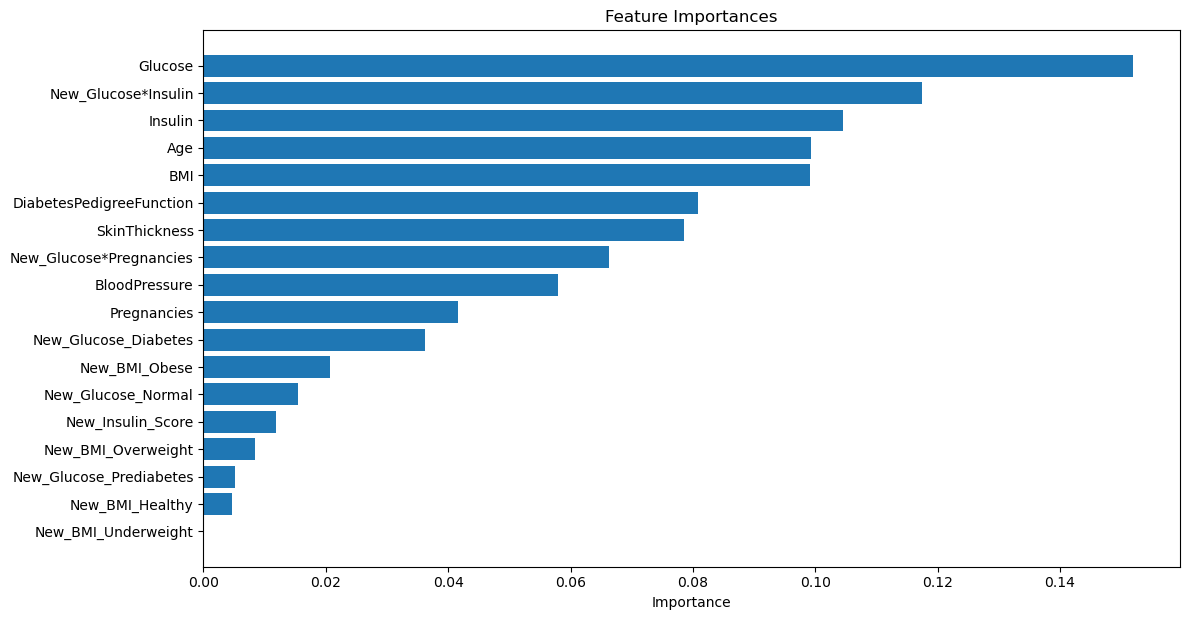

In [405]:
# Feature önem sırası 

feature_names_new = X_train_new_scaled.columns
importances_new = rf_model_new.feature_importances_

feat_importance_new = pd.DataFrame({
    "Feature": feature_names_new,
    "Importance": importances_new
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(12, max(6, len(feat_importance_new) * 0.35)))
plt.barh(feat_importance_new["Feature"], feat_importance_new["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [120]:
# Modele çok etkisi olmayan sütunlar
features_to_drop = [
    "New_BMI_Underweight",
    "New_BMI_Healthy", 
    "New_BMI_Overweight",
    "New_Glucose_Prediabetes",
    "New_Glucose_Normal",
     "New_Insulin_Score"   
]

# Sadece modelleme için yeni bir X oluşturuldu
X_new_reduced = X_new.drop(features_to_drop, axis=1)


* Modele çok etkisi olmayan sütunların silinmesinin ardından modeller tekrar kıyaslandı 


In [205]:
X_train_new_reduced, X_test_new_reduced, y_train_new_reduced, y_test_new_reduced = train_test_split(
    X_new_reduced, y_new, test_size=0.2, random_state=42
)

numeric_cols_new_reduced = X_new_reduced.select_dtypes(include=["int64", "float64"]).columns.tolist()

scaler_reduced = StandardScaler()
X_train_new_reduced_scaled = X_train_new_reduced.copy()
X_test_new_reduced_scaled = X_test_new_reduced.copy()
X_train_new_reduced_scaled[numeric_cols_new_reduced] = scaler_reduced.fit_transform(X_train_new_reduced[numeric_cols_new_reduced])
X_test_new_reduced_scaled[numeric_cols_new_reduced] = scaler_reduced.transform(X_test_new_reduced[numeric_cols_new_reduced])

# 4. Logistic Regression modeli
log_model_new_reduced = LogisticRegression()
log_model_new_reduced.fit(X_train_new_reduced_scaled, y_train_new_reduced)


y_pred_new_reduced = log_model_new_reduced.predict(X_test_new_reduced_scaled)

print("Logistic Regression (Reduced Features, new_df, scaled) sonuçlar:")
print(f"Accuracy : {round(accuracy_score(y_test_new_reduced, y_pred_new_reduced), 2)}")
print(f"Recall   : {round(recall_score(y_test_new_reduced, y_pred_new_reduced), 2)}")
print(f"Precision: {round(precision_score(y_test_new_reduced, y_pred_new_reduced), 2)}")
print(f"F1       : {round(f1_score(y_test_new_reduced, y_pred_new_reduced), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new_reduced, y_pred_new_reduced), 2)}")

Logistic Regression (Reduced Features, new_df, scaled) sonuçlar:
Accuracy : 0.74
Recall   : 0.65
Precision: 0.63
F1       : 0.64
AUC      : 0.72


Lojistik regresyon (new_df + scaled) Sonuçları:
* Accuracy: 0.73
* Recall: 0.65
* Precision: 0.61
* F1: 0.63
* Auc: 0.71

Lojistik Regresyon Sonuçları (Feature Engineering ve Ölçekleme Öncesi, Orijinal df):
* Accuracy: 0.77
* Recall: 0.64
* Precision: 0.69
* F1: 0.66
* Auc: 0.74

In [440]:

knn_model_new_reduced = KNeighborsClassifier()
knn_model_new_reduced.fit(X_train_new_reduced_scaled, y_train_new_reduced)


y_pred_knn_new_reduced = knn_model_new_reduced.predict(X_test_new_reduced_scaled)


print("KNN (Reduced Features, new_df, scaled) sonuçları:")
print(f"Accuracy : {round(accuracy_score(y_test_new_reduced, y_pred_knn_new_reduced), 2)}")
print(f"Recall   : {round(recall_score(y_test_new_reduced, y_pred_knn_new_reduced), 2)}")
print(f"Precision: {round(precision_score(y_test_new_reduced, y_pred_knn_new_reduced), 2)}")
print(f"F1       : {round(f1_score(y_test_new_reduced, y_pred_knn_new_reduced), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new_reduced, y_pred_knn_new_reduced), 2)}") 


KNN (Reduced Features, new_df, scaled) sonuçları:
Accuracy : 0.73
Recall   : 0.69
Precision: 0.61
F1       : 0.65
AUC      : 0.72


KNN (new_df + scaled) Sonuçları:
* Accuracy : 0.77
* Recall   : 0.67
* Precision: 0.67
* F1       : 0.67
* AUC      : 0.75

KNN (Feature Engineering ve Ölçekleme Öncesi, Orijinal df):
* Accuracy: 0.72
* Recall: 0.71
* Precision: 0.59
* F1: 0.64
* Auc: 0.72

In [207]:
lgbm_model_new_reduced = lgb.LGBMClassifier()
lgbm_model_new_reduced.fit(X_train_new_reduced_scaled, y_train_new_reduced)


y_pred_lgbm_new_reduced = lgbm_model_new_reduced.predict(X_test_new_reduced_scaled)


print("LightGBM (Reduced Features, new_df, scaled) Results:")
print(f"Accuracy : {round(accuracy_score(y_test_new_reduced, y_pred_lgbm_new_reduced), 2)}")
print(f"Recall   : {round(recall_score(y_test_new_reduced, y_pred_lgbm_new_reduced), 2)}")
print(f"Precision: {round(precision_score(y_test_new_reduced, y_pred_lgbm_new_reduced), 2)}")
print(f"F1       : {round(f1_score(y_test_new_reduced, y_pred_lgbm_new_reduced), 2)}")
print(f"AUC      : {round(roc_auc_score(y_test_new_reduced, y_pred_lgbm_new_reduced), 2)}")

LightGBM (Reduced Features, new_df, scaled) Results:
Accuracy : 0.75
Recall   : 0.73
Precision: 0.62
F1       : 0.67
AUC      : 0.74


LightGBM (new_df + scaled) Sonuçları:
* Accuracy : 0.73
* Recall   : 0.69
* Precision: 0.60
* F1       : 0.64
* AUC      : 0.72

LightGBM (Feature Engineering ve Ölçekleme Öncesi, Orijinal df):
* Accuracy: 0.77
* Recall: 0.76
* Precision: 0.65
* F1: 0.70
* Auc: 0.77

Denediğim modeller arasında en kayda değer sonuçları veren 3 model şu şekilde:

1) New Features ve scaling öncesi Logistic regresyon
2) New Features ve scaling öncesi LightGBM
3) New Features + scaling sonrası Random Forest

Yukarıda bahsedilen modellerin farklı veri bölmelerinde, nasıl performans gösterdiğini anlamak ve daha güvenilir bir başarı metriği elde etmek için 5 katlı çapraz doğrulama (5-Fold Cross Validation) yapıldı. 

In [195]:
scoring = ["accuracy", "recall", "precision", "f1", "roc_auc"]

cv_results = cross_validate(
    LogisticRegression(),
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

print("New Features ve scaling öncesi Logistic regresyon:\n")


for score in scoring:
    print(f"{score.capitalize()} (mean): {cv_results['test_' + score].mean():.2f}")
    print(f"All fold {score} scores: {cv_results['test_' + score]}")
    print("---")

New Features ve scaling öncesi Logistic regresyon:

Accuracy (mean): 0.77
All fold accuracy scores: [0.75974026 0.74675325 0.76623377 0.80392157 0.78431373]
---
Recall (mean): 0.57
All fold recall scores: [0.55555556 0.59259259 0.55555556 0.62264151 0.50943396]
---
Precision (mean): 0.73
All fold precision scores: [0.69767442 0.65306122 0.71428571 0.76744186 0.79411765]
---
F1 (mean): 0.63
All fold f1 scores: [0.6185567  0.62135922 0.625      0.6875     0.62068966]
---
Roc_auc (mean): 0.83
All fold roc_auc scores: [0.81648148 0.81611111 0.83166667 0.88150943 0.82415094]
---


In [193]:
cv_lgbm_results = cross_validate(
    lgbm_model,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)
print("New Features ve scaling öncesi LightGBM:\n")


for score in scoring:
    print(f"{score.capitalize()} (mean): {cv_lgbm_results['test_' + score].mean():.2f}")
    print(f"All fold {score} scores: {cv_lgbm_results['test_' + score]}")
    print("---")

New Features ve scaling öncesi LightGBM:

Accuracy (mean): 0.73
All fold accuracy scores: [0.73376623 0.7012987  0.67532468 0.77777778 0.74509804]
---
Recall (mean): 0.58
All fold recall scores: [0.61111111 0.64814815 0.38888889 0.66037736 0.58490566]
---
Precision (mean): 0.61
All fold precision scores: [0.62264151 0.56451613 0.55263158 0.68627451 0.64583333]
---
F1 (mean): 0.59
All fold f1 scores: [0.61682243 0.60344828 0.45652174 0.67307692 0.61386139]
---
Roc_auc (mean): 0.81
All fold roc_auc scores: [0.79462963 0.7687037  0.79166667 0.85867925 0.81830189]
---


In [191]:

scaler = StandardScaler()
X_new_cv_scaled = scaler.fit_transform(X_new) #Cross-validation işlemi için veriler tekrar ölçeklendirildi.

cv_rf_results = cross_validate(
    rf_model_new,
    X_new_cv_scaled,   # scaled tüm feature'lar
    y_new,             # hedef değişken
    cv=5,
    scoring=scoring,
    return_train_score=False
)

print("New Features + scaling sonrası Random Forest:\n")


for score in scoring:
    print(f"{score.capitalize()} (mean): {cv_rf_results['test_' + score].mean():.2f}")
    print(f"All fold {score} scores: {cv_rf_results['test_' + score]}")
    print("---")


New Features + scaling sonrası Random Forest:

Accuracy (mean): 0.76
All fold accuracy scores: [0.74025974 0.74025974 0.75974026 0.81045752 0.74509804]
---
Recall (mean): 0.58
All fold recall scores: [0.61111111 0.64814815 0.5        0.62264151 0.52830189]
---
Precision (mean): 0.69
All fold precision scores: [0.63461538 0.625      0.72972973 0.78571429 0.66666667]
---
F1 (mean): 0.63
All fold f1 scores: [0.62264151 0.63636364 0.59340659 0.69473684 0.58947368]
---
Roc_auc (mean): 0.82
All fold roc_auc scores: [0.80064815 0.79157407 0.85037037 0.87471698 0.8004717 ]
---


* Modellerimin recall değerini artırmak amacıyla, threshold değerleri azaltılarak recall üzerindeki etkisinin incelenmesi:

In [217]:
# Random forest modeli için optimal eşik değerini bulma:

# Test veri setinde olasılık skorların alınması
y_probs = rf_model_new.predict_proba(X_test_new_scaled)[:, 1]  

thresholds = np.arange(0.15, 0.75, 0.05) 

for t in thresholds:
    y_pred_custom = (y_probs >= t).astype(int)
    print(
        f"Threshold: {t:.2f} "
        f"| Accuracy: {accuracy_score(y_test_new, y_pred_custom):.2f} "
        f"| Recall: {recall_score(y_test_new, y_pred_custom):.2f} "
        f"| Precision: {precision_score(y_test_new, y_pred_custom, zero_division=0):.2f} "
        f"| F1: {f1_score(y_test_new, y_pred_custom):.2f} "
        f"| AUC: {roc_auc_score(y_test_new, y_pred_custom):.2f}"
    )

Threshold: 0.15 | Accuracy: 0.63 | Recall: 0.93 | Precision: 0.49 | F1: 0.64 | AUC: 0.70
Threshold: 0.20 | Accuracy: 0.66 | Recall: 0.91 | Precision: 0.52 | F1: 0.66 | AUC: 0.72
Threshold: 0.25 | Accuracy: 0.71 | Recall: 0.91 | Precision: 0.56 | F1: 0.69 | AUC: 0.75
Threshold: 0.30 | Accuracy: 0.73 | Recall: 0.89 | Precision: 0.58 | F1: 0.71 | AUC: 0.77
Threshold: 0.35 | Accuracy: 0.75 | Recall: 0.82 | Precision: 0.62 | F1: 0.70 | AUC: 0.77
Threshold: 0.40 | Accuracy: 0.76 | Recall: 0.80 | Precision: 0.63 | F1: 0.70 | AUC: 0.77
Threshold: 0.45 | Accuracy: 0.77 | Recall: 0.76 | Precision: 0.65 | F1: 0.70 | AUC: 0.77
Threshold: 0.50 | Accuracy: 0.78 | Recall: 0.73 | Precision: 0.68 | F1: 0.70 | AUC: 0.77
Threshold: 0.55 | Accuracy: 0.77 | Recall: 0.65 | Precision: 0.69 | F1: 0.67 | AUC: 0.75
Threshold: 0.60 | Accuracy: 0.79 | Recall: 0.64 | Precision: 0.74 | F1: 0.69 | AUC: 0.76
Threshold: 0.65 | Accuracy: 0.79 | Recall: 0.55 | Precision: 0.79 | F1: 0.65 | AUC: 0.73
Threshold: 0.70 | Acc

Threshold değeri 0.15’e çekildiğinde, model tüm gerçek hastaların %93’ünü başarıyla tespit edebilmektedir (recall=0.93). Ancak, hasta olarak sınıflandırılan bireylerin yalnızca %49’u gerçekten hastadır (precision=0.49). Bu durum, modelin birçok sağlıklı bireyi de yanlışlıkla hasta olarak etiketlemesine yol açmaktadır.

In [219]:
# Lojistik regresyon için optimal eşik değerini bulma:


y_probs_lg = model.predict_proba(X_test)[:, 1]


for t in thresholds:
    y_pred_log = (y_probs_lg >= t).astype(int)
    print(
        f"Threshold: {t:.2f} "
        f"| Accuracy: {accuracy_score(y_test, y_pred_log):.2f} "
        f"| Recall: {recall_score(y_test,y_pred_log):.2f} "
        f"| Precision: {precision_score(y_test, y_pred_log, zero_division=0):.2f} "
        f"| F1: {f1_score(y_test, y_pred_log):.2f} "
        f"| AUC: {roc_auc_score(y_test, y_pred_log):.2f}"
    )

Threshold: 0.15 | Accuracy: 0.62 | Recall: 0.95 | Precision: 0.49 | F1: 0.64 | AUC: 0.69
Threshold: 0.20 | Accuracy: 0.66 | Recall: 0.89 | Precision: 0.52 | F1: 0.65 | AUC: 0.71
Threshold: 0.25 | Accuracy: 0.68 | Recall: 0.80 | Precision: 0.53 | F1: 0.64 | AUC: 0.70
Threshold: 0.30 | Accuracy: 0.71 | Recall: 0.78 | Precision: 0.57 | F1: 0.66 | AUC: 0.72
Threshold: 0.35 | Accuracy: 0.71 | Recall: 0.71 | Precision: 0.57 | F1: 0.63 | AUC: 0.71
Threshold: 0.40 | Accuracy: 0.72 | Recall: 0.69 | Precision: 0.59 | F1: 0.64 | AUC: 0.71
Threshold: 0.45 | Accuracy: 0.74 | Recall: 0.67 | Precision: 0.63 | F1: 0.65 | AUC: 0.73
Threshold: 0.50 | Accuracy: 0.77 | Recall: 0.64 | Precision: 0.69 | F1: 0.66 | AUC: 0.74
Threshold: 0.55 | Accuracy: 0.77 | Recall: 0.60 | Precision: 0.70 | F1: 0.65 | AUC: 0.73
Threshold: 0.60 | Accuracy: 0.79 | Recall: 0.58 | Precision: 0.78 | F1: 0.67 | AUC: 0.75
Threshold: 0.65 | Accuracy: 0.80 | Recall: 0.56 | Precision: 0.82 | F1: 0.67 | AUC: 0.75
Threshold: 0.70 | Acc

In [221]:
# LightGBM için optimal eşik değerini bulma:

y_probs_lgbm= lgbm_model.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_pred_lgbm_tresh = (y_probs_lgbm >= t).astype(int)
    print(
        f"Threshold: {t:.2f} "
        f"| Accuracy: {accuracy_score(y_test, y_pred_lgbm_tresh):.2f} "
        f"| Recall: {recall_score(y_test,y_pred_lgbm_tresh):.2f} "
        f"| Precision: {precision_score(y_test, y_pred_lgbm_tresh, zero_division=0):.2f} "
        f"| F1: {f1_score(y_test, y_pred_lgbm_tresh):.2f} "
        f"| AUC: {roc_auc_score(y_test,y_pred_lgbm_tresh):.2f}"
    )

Threshold: 0.15 | Accuracy: 0.71 | Recall: 0.87 | Precision: 0.56 | F1: 0.69 | AUC: 0.75
Threshold: 0.20 | Accuracy: 0.73 | Recall: 0.87 | Precision: 0.58 | F1: 0.70 | AUC: 0.76
Threshold: 0.25 | Accuracy: 0.75 | Recall: 0.87 | Precision: 0.61 | F1: 0.72 | AUC: 0.78
Threshold: 0.30 | Accuracy: 0.75 | Recall: 0.87 | Precision: 0.61 | F1: 0.72 | AUC: 0.78
Threshold: 0.35 | Accuracy: 0.77 | Recall: 0.85 | Precision: 0.63 | F1: 0.72 | AUC: 0.79
Threshold: 0.40 | Accuracy: 0.75 | Recall: 0.82 | Precision: 0.62 | F1: 0.70 | AUC: 0.77
Threshold: 0.45 | Accuracy: 0.75 | Recall: 0.78 | Precision: 0.61 | F1: 0.69 | AUC: 0.75
Threshold: 0.50 | Accuracy: 0.77 | Recall: 0.76 | Precision: 0.65 | F1: 0.70 | AUC: 0.77
Threshold: 0.55 | Accuracy: 0.75 | Recall: 0.71 | Precision: 0.64 | F1: 0.67 | AUC: 0.74
Threshold: 0.60 | Accuracy: 0.75 | Recall: 0.65 | Precision: 0.64 | F1: 0.65 | AUC: 0.73
Threshold: 0.65 | Accuracy: 0.73 | Recall: 0.60 | Precision: 0.63 | F1: 0.62 | AUC: 0.70
Threshold: 0.70 | Acc

 LightGBM için treshold=35 oldukça dengeli gözükmektedir.

In [306]:
# KNN için optimal eşik değerini bulma:

y_probs_knn = knn_model_new.predict_proba(X_test_new_scaled)[:, 1]  

for t in thresholds:
    y_pred_knn_tresh = (y_probs_knn >= t).astype(int)
    print(
        f"Threshold: {t:.2f} "
        f"| Accuracy: {accuracy_score(y_test_new, y_pred_knn_tresh):.2f} "
        f"| Recall: {recall_score(y_test_new, y_pred_knn_tresh):.2f} "
        f"| Precision: {precision_score(y_test_new, y_pred_knn_tresh, zero_division=0):.2f} "
        f"| F1: {f1_score(y_test_new, y_pred_knn_tresh):.2f} "
        f"| AUC: {roc_auc_score(y_test_new, y_pred_knn_tresh):.2f}"
    )


Threshold: 0.15 | Accuracy: 0.59 | Recall: 0.91 | Precision: 0.46 | F1: 0.61 | AUC: 0.66
Threshold: 0.20 | Accuracy: 0.59 | Recall: 0.91 | Precision: 0.46 | F1: 0.61 | AUC: 0.66
Threshold: 0.25 | Accuracy: 0.69 | Recall: 0.84 | Precision: 0.55 | F1: 0.66 | AUC: 0.73
Threshold: 0.30 | Accuracy: 0.69 | Recall: 0.84 | Precision: 0.55 | F1: 0.66 | AUC: 0.73
Threshold: 0.35 | Accuracy: 0.69 | Recall: 0.84 | Precision: 0.55 | F1: 0.66 | AUC: 0.73
Threshold: 0.40 | Accuracy: 0.77 | Recall: 0.67 | Precision: 0.67 | F1: 0.67 | AUC: 0.75
Threshold: 0.45 | Accuracy: 0.77 | Recall: 0.67 | Precision: 0.67 | F1: 0.67 | AUC: 0.75
Threshold: 0.50 | Accuracy: 0.77 | Recall: 0.67 | Precision: 0.67 | F1: 0.67 | AUC: 0.75
Threshold: 0.55 | Accuracy: 0.77 | Recall: 0.67 | Precision: 0.67 | F1: 0.67 | AUC: 0.75
Threshold: 0.60 | Accuracy: 0.71 | Recall: 0.33 | Precision: 0.72 | F1: 0.45 | AUC: 0.63
Threshold: 0.65 | Accuracy: 0.71 | Recall: 0.33 | Precision: 0.72 | F1: 0.45 | AUC: 0.63
Threshold: 0.70 | Acc

Optimum eşik değeri ve model seçimi, uygulamanın riskine, önceliklerine ve amacına bağlı olarak değişmektedir.
Recall: Modelin pozitifleri (hasta olanlar) kaçırmama becerisini gösterir, ama tek başına genel başarıyı göstermez.
Gerçek başarı, modelin tüm metriklerde dengeli performans göstermesidir.
Sağlık gibi alanlarda recall çok önemlidir, ama yanlış pozitiflerin sayısı (precision) da göz ardı edilmemelidir.

NOT: Kullandığım modellerde hep random state=42 oranıyla işlem yaptım. 
Modelin farklı veri bölmelerinde, nasıl performans gösterdiğini anlamak ve daha güvenilir bir başarı metriği elde etmek için 5 katlı çapraz doğrulama (5-Fold Cross Validation) yapmak faydalı olacaktır.

In [304]:
from sklearn.model_selection import StratifiedKFold

# LightGBM için 5-Fold Cross Validation

threshold = 0.15
n_splits = 5

accs, recalls, precisions, f1s, aucs = [], [], [], [], []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_tr, y_tr)
    
    y_probs = lgbm.predict_proba(X_te)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    
    accs.append(accuracy_score(y_te, y_pred))
    recalls.append(recall_score(y_te, y_pred))
    precisions.append(precision_score(y_te, y_pred, zero_division=0))
    f1s.append(f1_score(y_te, y_pred))
    aucs.append(roc_auc_score(y_te, y_pred))

print(f"Threshold: {threshold}")
print(f"Accuracy (mean): {np.mean(accs):.2f} | All folds: {np.round(accs, 2)}")
print(f"Recall   (mean): {np.mean(recalls):.2f} | All folds: {np.round(recalls, 2)}")
print(f"Precision(mean): {np.mean(precisions):.2f} | All folds: {np.round(precisions, 2)}")
print(f"F1      (mean): {np.mean(f1s):.2f} | All folds: {np.round(f1s, 2)}")
print(f"AUC     (mean): {np.mean(aucs):.2f} | All folds: {np.round(aucs, 2)}")

Threshold: 0.15
Accuracy (mean): 0.72 | All folds: [0.75 0.74 0.73 0.72 0.67]
Recall   (mean): 0.82 | All folds: [0.89 0.74 0.81 0.83 0.83]
Precision(mean): 0.57 | All folds: [0.59 0.61 0.58 0.56 0.52]
F1      (mean): 0.67 | All folds: [0.71 0.67 0.68 0.67 0.64]
AUC     (mean): 0.74 | All folds: [0.78 0.74 0.75 0.75 0.71]


In [267]:
# Threshold 0.35 olduğunda:

# Accuracy (mean): 0.74 | All folds: [0.79 0.74 0.77 0.72 0.71]
# Recall   (mean): 0.69 | All folds: [0.76 0.63 0.69 0.68 0.68]
# Precision(mean): 0.62 | All folds: [0.68 0.63 0.66 0.58 0.56]
# F1      (mean): 0.65 | All folds: [0.72 0.63 0.67 0.63 0.62]
# AUC     (mean): 0.73 | All folds: [0.78 0.71 0.75 0.71 0.7]


In [275]:
# Lojistik regresyon için 5-Fold Cross Validation

threshold = 0.20
n_splits = 5

accs, recalls, precisions, f1s, aucs = [], [], [], [], []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    model = LogisticRegression()
    model.fit(X_tr, y_tr)

    y_probs = model.predict_proba(X_te)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    accs.append(accuracy_score(y_te, y_pred))
    recalls.append(recall_score(y_te, y_pred))
    precisions.append(precision_score(y_te, y_pred, zero_division=0))
    f1s.append(f1_score(y_te, y_pred))
    aucs.append(roc_auc_score(y_te, y_pred))

print(f"Threshold: {threshold}")
print(f"Accuracy (mean): {np.mean(accs):.2f} | All folds: {np.round(accs, 2)}")
print(f"Recall   (mean): {np.mean(recalls):.2f} | All folds: {np.round(recalls, 2)}")
print(f"Precision(mean): {np.mean(precisions):.2f} | All folds: {np.round(precisions, 2)}")
print(f"F1      (mean): {np.mean(f1s):.2f} | All folds: {np.round(f1s, 2)}")
print(f"AUC     (mean): {np.mean(aucs):.2f} | All folds: {np.round(aucs, 2)}")

Threshold: 0.2
Accuracy (mean): 0.67 | All folds: [0.67 0.72 0.65 0.69 0.64]
Recall   (mean): 0.92 | All folds: [0.94 0.89 0.94 0.85 0.96]
Precision(mean): 0.52 | All folds: [0.52 0.56 0.5  0.53 0.49]
F1      (mean): 0.66 | All folds: [0.67 0.69 0.65 0.65 0.65]
AUC     (mean): 0.73 | All folds: [0.73 0.76 0.72 0.72 0.72]


In [271]:

# Threshold 0.15 olduğunda:

#Accuracy (mean): 0.63 | All folds: [0.65 0.66 0.59 0.67 0.56]
#Recall   (mean): 0.96 | All folds: [0.98 0.94 0.96 0.96 0.96]
#Precision(mean): 0.48 | All folds: [0.5  0.51 0.46 0.51 0.44]
#F1      (mean): 0.64 | All folds: [0.66 0.66 0.62 0.67 0.6 ]
#AUC     (mean): 0.70 | All folds: [0.73 0.73 0.68 0.74 0.66]

# Threshold 0.20, modelin başarısı açısından threshold 0.15’ten daha iyidir.
# Çünkü neredeyse aynı yüksek recall ile, çok daha yüksek doğruluk, precision ve F1 skoruna ulaşıyor.


In [296]:
# RandomForestClassifier için 5-Fold Cross Validation


threshold = 0.35  
n_splits = 5      

accs, recalls, precisions, f1s, aucs = [], [], [], [], []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X_new, y_new):
    X_tr, X_te = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_tr, y_te = y_new.iloc[train_idx], y_new.iloc[test_idx]


    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_scaled, y_tr)


    y_probs = rf.predict_proba(X_te_scaled)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    accs.append(accuracy_score(y_te, y_pred))
    recalls.append(recall_score(y_te, y_pred))
    precisions.append(precision_score(y_te, y_pred, zero_division=0))
    f1s.append(f1_score(y_te, y_pred))
    aucs.append(roc_auc_score(y_te, y_pred))

print(f"Threshold: {threshold}")
print(f"Accuracy (mean): {np.mean(accs):.2f} | All folds: {np.round(accs, 2)}")
print(f"Recall   (mean): {np.mean(recalls):.2f} | All folds: {np.round(recalls, 2)}")
print(f"Precision(mean): {np.mean(precisions):.2f} | All folds: {np.round(precisions, 2)}")
print(f"F1      (mean): {np.mean(f1s):.2f} | All folds: {np.round(f1s, 2)}")
print(f"AUC     (mean): {np.mean(aucs):.2f} | All folds: {np.round(aucs, 2)}")

Threshold: 0.35
Accuracy (mean): 0.75 | All folds: [0.78 0.77 0.77 0.76 0.66]
Recall   (mean): 0.82 | All folds: [0.87 0.74 0.81 0.85 0.81]
Precision(mean): 0.61 | All folds: [0.64 0.66 0.63 0.62 0.51]
F1      (mean): 0.70 | All folds: [0.73 0.7  0.71 0.71 0.62]
AUC     (mean): 0.76 | All folds: [0.8  0.77 0.78 0.78 0.7 ]


* Random Forest (Threshold 0.35), LightGBM (Threshold 0.15)'e göre metriklerde daha yüksek performans göstermektedir.
* Recall eşit; fakat RF’nin accuracy, precision, F1 ve AUC değerleri daha yüksek.
* Bu nedenle, Random Forest daha iyi bir seçimdir.

LightGBM (Threshold 0.15):

* Accuracy (mean): 0.72 | All folds: [0.75 0.74 0.73 0.72 0.67]
* Recall   (mean): 0.82 | All folds: [0.89 0.74 0.81 0.83 0.83]
* Precision(mean): 0.57 | All folds: [0.59 0.61 0.58 0.56 0.52]
* F1      (mean): 0.67 | All folds: [0.71 0.67 0.68 0.67 0.64]
* AUC     (mean): 0.74 | All folds: [0.78 0.74 0.75 0.75 0.71]

Eşik değerli tüm çapraz doğrulama sonuçları değerlendirildiğinde, en iyi genel performansın Random Forest modeliyle (Threshold 0.35) elde edildiği görülmektedir. Bu model; Accuracy, Precision, F1 ve AUC metriklerinde en yüksek değerlere ulaşarak diğer modellerin önüne geçmiştir. Recall değeri ise LightGBM ile aynı seviyede (%82) olup, lojistik regresyon modelinden (%92) bir miktar düşük olsa da, Random Forest modelinin genel başarı ve denge açısından daha üstün olduğu anlaşılmaktadır. Ayrıca, yapılan tüm işlemler (yeni feature oluşturma, ölçeklendirme vb.) Random Forest modelinin veriden daha iyi anlam çıkarmasını sağlamış ve model performansını güçlendirmiştir.